## Tensorflow Linear Regression

### Low-Level API
Intuitively, Low-level API is more powerful and flexible, yet less efficient to develop. Here we set up a dataset pipeline with batch size 10. Then find gradient to this batch using automatic differentiation tape, and update slope and intercept with gradient descent. The code is as below.

In [9]:
import tensorflow as tf
import numpy as np

tf.random.set_seed(0)
np.random.seed(0)

sample_size = 500
batch_size = 10
sigma_e = 3.0             # true value of parameter error sigma
xs = 100 * np.random.rand(sample_size)
es = np.random.normal(0, sigma_e, sample_size)
ys = 1.0 + 2.0 * xs + es

ds = tf.data.Dataset.from_tensor_slices((xs, ys)).shuffle(buffer_size=sample_size).batch(batch_size)
for x, y in ds.take(1):         # take first batch
    print(x, y)

w = tf.Variable(tf.random.normal(shape=[1], dtype=tf.float64))      # scaler, shape=[] or shape=[1,]
b = tf.Variable(0,  dtype = tf.float64)          # scaler

epochs = 100
learning_rate = 0.001
ws = []
bs = []
for epoch in tf.range(1,epochs+1):      # for each epoch
  for x, y in ds:           # for each batch
    with tf.GradientTape() as tape:
      y_bar = x*w + b                    # broadcasting
      loss = tf.sqrt(tf.reduce_mean( (y-y_bar)**2 ))
      # loss = tf.reduce_mean( (y-y_bar)**2 )
    # Back propagation to calculate gradient
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
    # apply_gradients
    w.assign(w - learning_rate * dloss_dw)         # assign, keeps tf.Variable; operator ==> tf.Tensor
    b.assign(b - learning_rate * dloss_db)
    ws.append(w.numpy()[0])
    bs.append(b.numpy())

  if epoch % 20 == 0:
    tf.print('w=', w[0], ' ,b=', b, ' ,mse=', loss)

tf.Tensor(
[94.53015335 42.40889884 42.40322519 84.90383084 43.44166256  2.01075462
 55.20782767 40.71832972 49.04588086 10.20448107], shape=(10,), dtype=float64) tf.Tensor(
[189.93610426  85.85229439  84.8538211  170.60625922  86.47141214
   3.74855637 115.39504027  81.28272318  97.11208653  21.64374268], shape=(10,), dtype=float64)
w= 2.0092433160037424  ,b= 0.083804579058864764  ,mse= 2.5152901410985193
w= 2.0133854164832647  ,b= 0.12503606117564978  ,mse= 3.411646932152868
w= 1.9745402878296359  ,b= 0.16570829832847597  ,mse= 2.181400506321292
w= 2.0332908978757693  ,b= 0.20492633276977917  ,mse= 1.9839655160821146
w= 1.9998285047327671  ,b= 0.23774513013090717  ,mse= 4.39657509939333


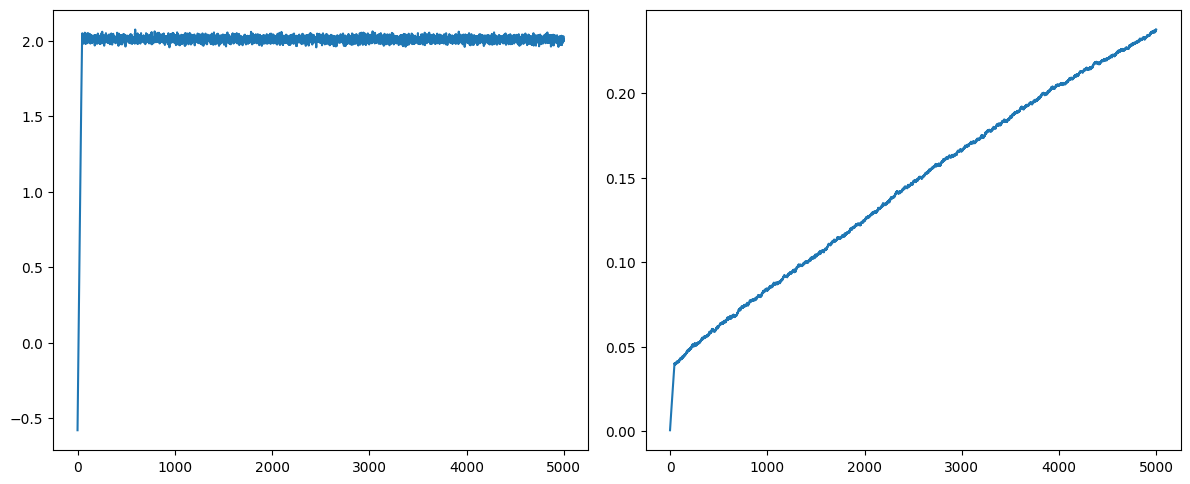

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.tight_layout()
axes[0].plot(ws)
axes[1].plot(bs)

### High-Level API
The high-level API of Tensorflow is Keras, which now becomes part of Tensorflow. It has a couple of elements, a model, a loss function as objective, and an optimizer to reach that objective.

In [13]:
import tensorflow as tf
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),          # explicit input “placeholder”
    tf.keras.layers.Dense(1)             # 2 trainable params
])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [17]:
epochs = 200
loss_fn  = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(1e-3)

for epoch in range(1, epochs + 1):
    for x_batch, y_batch in ds:               # each mini-batch
        with tf.GradientTape() as tape:
            y_pred = model(x_batch, training=True)
            loss   = loss_fn(y_batch, y_pred)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # monitor every 20 epochs
    if epoch % 20 == 0:
        w_val = model.layers[0].kernel.numpy()[0,0]
        b_val = model.layers[0].bias.numpy()[0]
        tf.print(f"epoch {epoch:3d}  w = {w_val:.3f}  b = {b_val:.3f}  mse = {loss:.4f}")

epoch  20  w = 2.003  b = 0.384  mse = 3.4609
epoch  40  w = 2.005  b = 0.400  mse = 5.6849
epoch  60  w = 2.004  b = 0.423  mse = 7.0026
epoch  80  w = 2.005  b = 0.458  mse = 8.5147
epoch 100  w = 2.005  b = 0.495  mse = 7.5988
epoch 120  w = 2.002  b = 0.529  mse = 19.8597
epoch 140  w = 2.004  b = 0.559  mse = 6.0343
epoch 160  w = 2.001  b = 0.579  mse = 9.3124
epoch 180  w = 2.005  b = 0.601  mse = 8.2628
epoch 200  w = 2.005  b = 0.615  mse = 7.9890
